# Description

This notebook contains the complete pipeline necessary to test and observe concepts covered upto 15/12/2024

This involves:
1. Jakes' Sum of Sinusoids 1D complex channel generation with Rayleigh's Multipath Fading

2. Random bit generation (-1 or 1), transmission and reception with noise of specified SNR and channel gain of specified autocorrelation

3. BPSK demodulation of received signals using estimated channel gains

4. Pipeline to assign some packets transmitted as headers and periodically transmit these headers, estimate channels of these headers using least squares, and demodulate all data within one coherence time from the header, so that the channel can be assumed constant in the data 

5. Pipeline to predict channel gains using a Vector AutoRegressive model that is trained on least-squares estimated channels that are developed by transmitting pilots first. When our predicted channels differ from a least-squares estimate of the channel for a packet in the future, then it means our prediction is wrong, and hence we retransmit pilots and retrain our VAR model on a fresh and accurate set of least-square estimated channels. 

6. Plotting the following:
    * Retransmission frequency (number of pilot bits transmitted/number of total bits transmitted) Vs Doppler Frequency for the VAR approach
    * Retransmission frequency Vs Doppler frequency for different MSE thresholds ranging from 0.01 to 0.1 for the VAR approach
    * BER vs SNR plot for the packet-and-header based approach (resulting in what is called a Waterfall plot) and the autoregression-based approach. 
    
The user must specify the Doppler frequency Fd, number of samples N, SNR value, MSE threshold and the Sampling Frequency Fs wherever required to observe corresponding outputs. 

# Importing necessary libraries and functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import json
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from sympy import Matrix
import json
import argparse

# Defining useful helper functions

In [5]:
def generate_random_bits(n):
    """
    Generate random bits as either -1 or 1.

    Args:
        n (int): Number of bits to generate.

    Returns:
        np.ndarray: Array of random bits (-1 or 1) of size n.
    """
    # Generate n random bits as -1 or 1 using uniform sampling.
    return np.random.choice([-1, 1], size=n)


def transmit_data(data, channel, snr_db):
    """
    Simulate data transmission over a wireless channel with noise.

    Args:
        data (np.ndarray): Input data to be transmitted.
        channel (complex or float): Channel gain.
        snr_db (float): Signal-to-noise ratio in decibels (dB). The formula to convert in linear scale is snr(dB) = 10log(snr(linear))

    Returns:
        np.ndarray: Noisy received signal.
    """
    # Apply channel gain to the transmitted data.
    signal = channel * data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise


def estimate_channel(received, data):
    """
    Estimate the channel coefficient using least squares.

    Args:
        received (np.ndarray): Received signal.
        data (np.ndarray): Transmitted data.

    Returns:
        complex or float: Estimated channel coefficient, of the same length as X, so a packetwise(pointwise) estimation is performed
    """
    # Reshape the transmitted data for matrix operations.
    X = data.reshape(-1, 1)
    # Perform least squares estimation to solve for the channel.
    h = np.linalg.lstsq(X, received, rcond=None)[0][0]
    return h


def collect_pilot_estimates(current_index, num_pilots, channel_vals):
    """
    Transmit pilots and get channel estimates which are then fed to autoregressive predictive models

    Args:
        current_index (int): Starting index at which pilots are retransmitted.
        num_pilots (int): Number of pilot transmissions to perform.
        channel_vals (np.ndarray): Array of actual channel values.

    Returns:
        tuple: 
            - estimates (list): List of estimated channel coefficients for each pilot.
            - current_index (int): Updated index after processing pilots.
    """
    # List to store channel estimates.
    estimates = []
    # Collect channel estimates for the specified number of pilots.
    for _ in range(num_pilots):
        # Check if the remaining channel values are sufficient for a pilot.
        if current_index + pilot_size > len(channel_vals):
            break

        # Generate pilot bits for transmission.
        pilot_bits = generate_random_bits(pilot_size)
        # Extract the actual channel values for the current pilot.
        actual_channel = channel_vals[current_index:current_index + pilot_size]
        # Simulate the transmission and reception of pilot data.
        received_pilot = transmit_data(pilot_bits, actual_channel, snr_db)
        # Estimate the channel from the received pilot data.
        hbar = estimate_channel(received_pilot, pilot_bits)
        # Store the estimated channel coefficient.
        estimates.append(hbar)
        # Move the index forward by the size of the pilot.
        current_index += pilot_size

    return estimates, current_index


def predict_channel_var(channel_history, steps=1):
    """
    Predict the future channel value using a Vector AutoRegressive (VAR) model.

    Args:
        channel_history (np.ndarray): Historical channel values as a 1D array of complex numbers.
        steps (int): Number of future steps to predict. Default is 1.

    Returns:
        complex: Predicted channel value as a complex number.

    Raises:
        ValueError: If the length of `channel_history` is less than or equal to the VAR model order.
    """
    # Ensure there are enough samples for the VAR model.
    if len(channel_history) <= var_order:
        raise ValueError(f"Not enough samples for VAR. Need >{var_order}, got {len(channel_history)}")
    # Separate real and imaginary parts of the channel history for the VAR model.
    channel_history_separated = np.column_stack((np.real(channel_history), np.imag(channel_history)))
    # Create and fit the VAR model using the specified order.
    model = VAR(channel_history_separated)
    results = model.fit(var_order)
    # Forecast future values based on the fitted model and past data.
    forecast = results.forecast(channel_history_separated[-var_order:], steps=steps)
    # Combine the real and imaginary parts to return the predicted complex channel value.
    return forecast[0, 0] + 1j * forecast[0, 1]


def generate_channels_for_doppler_frequencies(Fd, Fs, N):
    """
    Generate correlated Jakes channels for given Doppler frequencies using the Sum-of-Sinusoids (SoS) method.

    Args:
        Fd (float): Maximum Doppler frequency (Hz).
        Fs (float): Sampling frequency (Hz).
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Correlated Jakes random variables (complex values) for the generated channels.
    """
    def jakes_sos(P, K, Fs, Fd, N, typ):
        """
        Generate Jakes random variables using the Sum-of-Sinusoids (SoS) method.

        Args:
            P (int): Number of time points.
            K (int): Number of independent processes.
            Fs (float): Sampling frequency (Hz).
            Fd (float): Maximum Doppler frequency (Hz).
            N (int): Number of sinusoids used in the model.
            typ (str): Type of signal to generate ('comp' for complex, others for real).

        Returns:
            np.ndarray: Jakes random variables (complex values).
        """
        # Create a time vector for sampling points
        t = np.linspace(0, P / Fs, P)
        # Calculate angular Doppler frequency
        omega_d = 2 * np.pi * Fd
        # Initialize an array to store Jakes random variables
        jakes_rvs = np.zeros((K, P), dtype=complex)
        
        # Loop through independent processes
        for k in range(K):
            # Generate random angles for sinusoids
            alpha = np.random.uniform(0, 2 * np.pi, N)
            # Adjust angles based on the number of sinusoids
            alpha_m = np.array([((2 * np.pi * n) - np.pi + al) / (4 * N) for n, al in enumerate(alpha)])
            # Generate random phase offsets for cosine terms
            a_m = np.random.uniform(0, 2 * np.pi, N)
            # Generate random phase offsets for sine terms
            b_m = np.random.uniform(0, 2 * np.pi, N)
            # Compute cosine terms for the real part
            cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
            # Sum the cosine contributions to form the real part
            real_part = np.sqrt(1 / N) * np.sum(cosine_terms, axis=1)

            # Check if generating complex signals
            if typ == 'comp':
                # Compute sine terms for the imaginary part
                sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
                # Sum the sine contributions to form the imaginary part
                imag_part = np.sqrt(1 / N) * np.sum(sine_terms, axis=1)
                # Combine real and imaginary parts
                jakes_rvs[k] = real_part + 1j * imag_part
            else:
                # Enforce complex format with zero imaginary part for real signals
                jakes_rvs[k] = real_part + 1j * 0

        # Return the generated Jakes random variables
        return jakes_rvs

    # Number of time points for the output
    P = N
    # Number of independent processes to simulate
    K = 1
    # Specify the type of random variables (complex)
    typ = 'comp'
    # Set the center frequency
    Fc = 1000000000
    # Generate Jakes random variables using the SoS method
    jakes_rvs = jakes_sos(P, K, Fs, Fd, 100, typ)
    correlated_jakes_rvs = jakes_rvs

    # Open a file to write the generated channels
    with open("channels.txt", "w") as fo:
        # Iterate through each sample
        for i in range(P):
            # Extract the i-th sample
            new_sample = correlated_jakes_rvs[:, i]
            # Serialize complex numbers as (real, imag) pairs
            new_sample_serialized = [(z.real, z.imag) for z in new_sample]
            # Write serialized sample to the file
            json.dump(new_sample_serialized, fo)
            # Add a newline after each serialized sample
            fo.write('\n')

    # Return the generated Jakes random variables
    return correlated_jakes_rvs


# Defining functions to simulate 2 approaches to channel estimation

In [8]:
# Parameters
#The number of channel samples we estimate into the future 
packet_size = 50
#The number of pilot samples we transmit incase of retransmission
pilot_size = 50
#Order of our VAR model
var_order = 25
#MSE threshold to decide if a retransmission is required incase of VAR-based estimation
mse_threshold = 0.1
#SNR in dB
snr_db = 10 
#Minimum number of samples needed for VAR fitting + buffer
initial_pilots = var_order + 2  

In [10]:
def autoreg_simulate(Fd, Fs, mse_threshold, N, SNR):
    """
    Simulate an autoregressive channel estimation system with adaptive pilot requests.

    Args:
        Fd (float): Maximum Doppler frequency (Hz).
        Fs (float): Sampling frequency (Hz).
        mse_threshold (float): Mean squared error threshold for pilot retransmissions.
        N (int): Total number of samples in the channel.
        SNR (float): Signal-to-noise ratio (linear scale).

    Returns:
        tuple:
            - retrans_frequency (float): Retransmission frequency of pilots.
            - ber (float): Bit error rate of the system.
    """
    # Generate and save channels for the given Doppler frequency.
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    
    # Load the complex channel values from the file.
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])

    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    channel_estimates = []  # Store all channel estimates.
    pilot_requests = []  # Track indices where pilots are requested/retransmission begins.
    total_bits = 0  # Total number of transmitted bits.
    wrong_bits = 0  # Total number of incorrectly decoded bits.

    # Perform initial pilot transmissions to ensure enough samples for VAR.
    initial_estimates, current_index = collect_pilot_estimates(current_index, initial_pilots, channel_vals)
    channel_estimates.extend(initial_estimates)
    pilot_requests.extend(range(0, current_index, pilot_size))
    #initial_pilots refers to the number of retransmissions performed when the VAR needs to be trained again. Each retransmission involves sending pilot_size number of pilots
    total_bits += initial_pilots * pilot_size

    # Main loop for channel estimation and data transmission.
    while current_index < len(channel_vals) - packet_size:
        # Predict the channel using the VAR model based on past estimates.
        try:
            htilde = predict_channel_var(channel_estimates)
        except ValueError as e:
            break 
            
        # Generate random data bits for transmission.
        data_bits = generate_random_bits(packet_size)
        # Extract the actual channel values for the current packet.
        actual_channel = channel_vals[current_index:current_index + packet_size]
        # Simulate the transmission of data through the channel.
        received_data = transmit_data(data_bits, actual_channel, SNR)
        # Demodulate the received signal using the predicted channel estimate.
        dbar = np.sign(np.real(received_data * np.conjugate(htilde) / (np.abs(htilde)**2)))

        # Re-estimate the channel using the demodulated data.
        hnought = estimate_channel(received_data, dbar)        
        # Compute the mean squared error between predicted and re-estimated channels.
        mse = np.abs(htilde - hnought)**2

        # Check if the error exceeds the threshold.
        if mse > mse_threshold:
            # Collect new pilot estimates if error is too high.
            new_estimates, current_index = collect_pilot_estimates(current_index, initial_pilots, channel_vals)
            channel_estimates.extend(new_estimates)
            pilot_requests.extend(range(current_index - len(new_estimates) * pilot_size, current_index, pilot_size))
            total_bits += len(new_estimates) * pilot_size
        else:
            # Use the re-estimated channel and proceed with the simulation.
            channel_estimates.append(hnought)
            current_index += packet_size
            total_bits += packet_size

            # Count the number of incorrect bits in the transmitted data.
            for i in range(len(data_bits)):
                if data_bits[i] != dbar[i]:
                    wrong_bits += 1

            # Stop if approaching the end of the simulation window.
            if current_index >= N - packet_size:
                break

    # Calculate the retransmission frequency (pilot-to-data ratio).
    retrans_frequency = np.float16(1 / (total_bits / (len(pilot_requests) * pilot_size)))
    
    # Calculate the bit error rate (BER).
    ber = np.float16(wrong_bits / total_bits) if total_bits > 0 else 0

    # Return the retransmission frequency and BER.
    return retrans_frequency, ber


In [12]:
#Testing out the simulation for specific Fd, N and Fs values
Fs = 100000
retrans_frequency, ber = autoreg_simulate(1000, Fs, 0.1, 100000, 10)
print(retrans_frequency)
print(ber)

0.9854
0.00575


In [13]:
def packetwise_simulate(Fd, Fs, mse_threshold, N, SNR):
    """
    Simulate a packet-based channel estimation system with pilots and data transmission.

    Args:
        Fd (float): Maximum Doppler frequency (Hz).
        Fs (float): Sampling frequency (Hz).
        mse_threshold (float): Mean squared error threshold (unused in this function).
        N (int): Total number of samples in the channel.
        SNR (float): Signal-to-noise ratio (linear scale).

    Returns:
        float16 or None: Bit error rate (BER) for the transmission, or None if no packets were transmitted.
    """
    # Generate channels for the specified Doppler frequency and save to file.
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    
    # Load the complex channel values from the file.
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    actual_channels = []  # Store actual channel values.
    
    # Simulate the transmission of packets, each with 1 pilot and 3 data bits.
    while current_index < N - 4:  # Ensure enough channel values remain for the packet.
        # Transmit a single pilot bit, which acts as a header for the entire 4-bit packet.
        pilot_bit = generate_random_bits(1)
        actual_channel = channel_vals[current_index:current_index + 1]  
        actual_channels.append(actual_channel[0])  
        received_pilot = transmit_data(pilot_bit, actual_channel, SNR)  # Transmit and receive the pilot signal.
        estimated_channel = estimate_channel(received_pilot, pilot_bit)  # Estimate the channel from the pilot, which is assumed to be the channel for all the 3 data packets that follow

        # Move to the next index for data transmission.
        current_index += 1
        # Generate 3 data bits for the data packet.
        data_bits = generate_random_bits(3)
        # Check if enough channel values are available for the data packet.
        if current_index + 3 >= len(channel_vals):
            break
        
        # Use three consecutive channel values for data transmission.
        actual_channel = channel_vals[current_index:current_index + 3]
        # Transmit and receive the data packet.
        received_data = transmit_data(data_bits, actual_channel, SNR) 
        # Estimate the transmitted data bits using the channel of the pilot that we estimated earlier. 
        estimated_data_bits = np.sign(np.real(received_data * estimated_channel.conjugate() / (abs(estimated_channel))**2))
        
        # Update the total transmitted packets and count the errors.
        total_packets += 3
        for i in range(3):  # Compare each transmitted bit with the estimated bit.
            if data_bits[i] != estimated_data_bits[i]:
                wrong_packets += 1

        # Move the index forward by 3 for the next 4-bit (1 header + 3 data) packet transmission.
        current_index += 3

    # Calculate and return the Bit Error Rate (BER).
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)


In [14]:
#Testing out the simulation for specific Fd, N and Fs values
Fs = 100000
ber = packetwise_simulate(1000, Fs, 0.1, 100000, 10)
print(ber)

0.003521


# Plotting out retransmission frequency against Doppler frequency

In [18]:
# Specifying certain parameters
# Number of pilots we transmit in a single retransmission
pilot_size = 50
# Number of packets that we predict channels for into the future incase of autoregressive or sequence modelling
packet_size = 50
# Order of the VAR we are using 
var_order = 25 
# Number of channel samples or total (pilot + packet) samples
N = 100000
# MSE threshold to decide when resampling is to be done
mse_threshold = 0.1
# SNR of the channel to determine the level of noise in the received signal
SNR = 10 
# Sampling frequency of the simulation
Fs = 100000 
#Range of doppler frequencies to be explored in the plot - a total of 150 doppler frequencies
doppler_frequencies = np.linspace(0, 1700, 150)  
#Vectors to store the retransmission frequency and BER for plotting
retrans_frequencies = []
ber_values = []

#The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for Fd in doppler_frequencies:
    retrans_frequency = 0
    ber = 0
    for i in range(3):
        retrans_frequency1, ber1 = autoreg_simulate(Fd, Fs, mse_threshold, N, SNR)
        retrans_frequency += retrans_frequency1
        ber += ber1 
    retrans_frequencies.append(retrans_frequency/3)
    ber_values.append(ber/3)

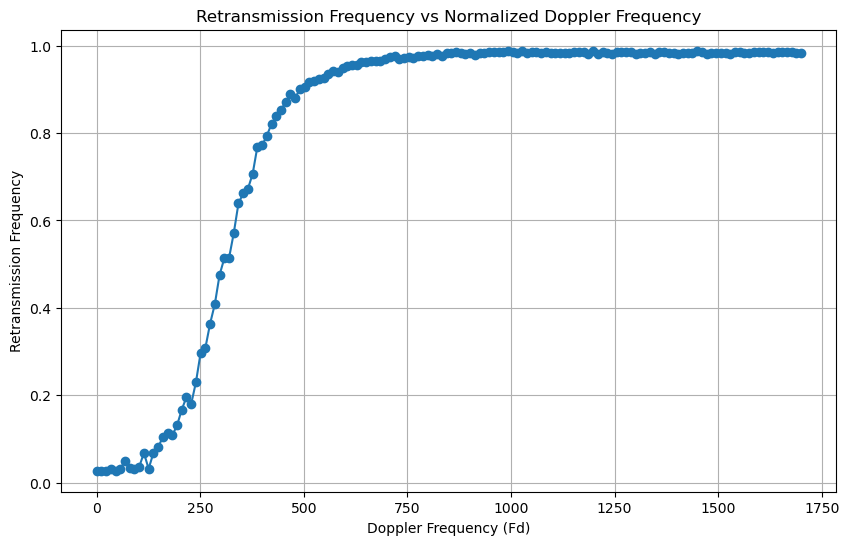

In [19]:
#Plot retransmission frequency vs normalized Doppler frequency
plt.figure(figsize=(10, 6))
plt.plot(doppler_frequencies, retrans_frequencies, 'o-', label='Retransmission Frequency')
plt.xlabel('Doppler Frequency (Fd)')
plt.ylabel('Retransmission Frequency')
plt.title('Retransmission Frequency vs Normalized Doppler Frequency')
plt.grid(True)
plt.show()

# Plotting retransmission frequency against Doppler frequency for different thresholds

In [21]:
# Range of MSE thresholds to be examined
thresholds = np.logspace(-2, -1, 5)
# Selected doppler frequencies to be plotted for each mse threshold
selected_dopplers = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Retransmission frequency values for each threshold
retrans_frequencies_dict = {thresh: [] for thresh in thresholds}
# Number of pilots we transmit in a single retransmission
pilot_size = 50 
# Order of the VAR we are using 
var_order = 25
# Number of channel samples or total (pilot + packet) samples
N = 100000
# SNR of the channel to determine the level of noise in the received signal
SNR = 10 
# Sampling frequency of the simulation
Fs = 100000

#The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for threshold in thresholds:
    for Fd in selected_dopplers:
        retrans_freq = 0
        for i in range(3):
            retrans_frequency1, _ = autoreg_simulate(Fd, Fs, threshold, N, SNR)
            retrans_freq += retrans_frequency1
        retrans_frequencies_dict[threshold].append(retrans_freq/3)
    

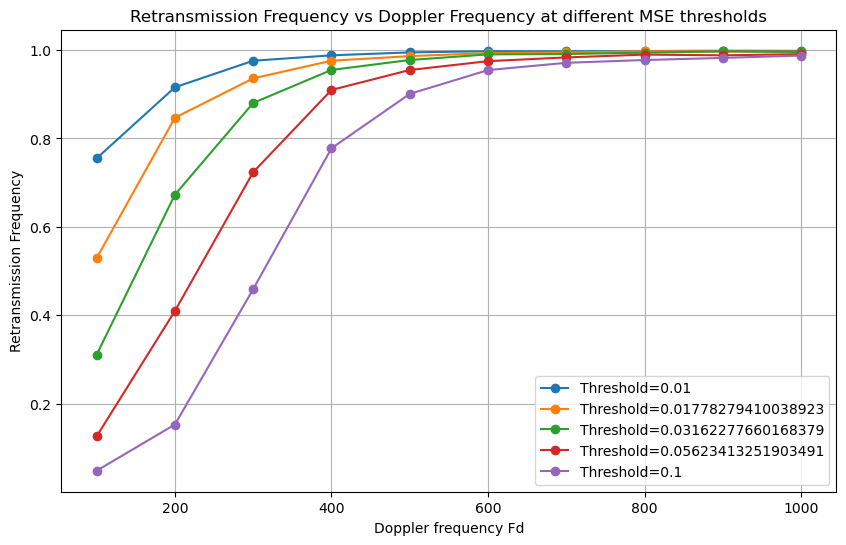

In [22]:
# Plot average retransmission frequency vs MSE threshold
plt.figure(figsize=(10, 6))
for thresh, avg_freqs in retrans_frequencies_dict.items():
    plt.plot(selected_dopplers, avg_freqs, 'o-', label=f'Threshold={thresh}')
plt.xlabel('Doppler frequency Fd')
plt.ylabel('Retransmission Frequency')
plt.title('Retransmission Frequency vs Doppler Frequency at different MSE thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting BER against SNR for the 2 channel estimation approaches we have

In [ ]:
# Define the range of SNR values to be simulated
snr_values = [-4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

# Parameters
# Number of bits in a pilot transmission
pilot_size = 50
# Order of the VAR model
var_order = 25  
# Total number of samples
N = 10000000  
# Threshold for MSE to trigger retransmissions
mse_threshold = 0.1 
# Sampling frequency in Hz
Fs = 100000  
# Doppler frequency in Hz
Fd = 100  

# Initialize lists to store BER for the two approaches
ber_autoreg_list = []  # BER for the autoregressive approach
ber_packetwise_list = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_autoreg_sum = 0  # For autoregressive approach
    ber_packetwise_sum = 0  # For packetwise approach
    for i in range(3):
        _, ber_autoreg = autoreg_simulate(Fd, Fs, mse_threshold, N, snr)
        ber_packetwise = packetwise_simulate(Fd, Fs, mse_threshold, N, snr)
        ber_autoreg_sum += ber_autoreg
        ber_packetwise_sum += ber_packetwise
    ber_autoreg_list.append(ber_autoreg_sum / 3)
    ber_packetwise_list.append(ber_packetwise_sum / 3)

In [ ]:
plt.figure(figsize=(10, 6))
snr_values_np = np.array(snr_values)
# Plot the BER for the autoregressive approach
plt.plot(snr_values_np/2, ber_autoreg_list, marker='o', linestyle='-', label='Autoregressive Approach')
# Plot the BER for the packetwise approach
plt.plot(snr_values_np/2, ber_packetwise_list, marker='s', linestyle='--', label='Packetwise Approach')
# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs SNR for Autoregressive and Packetwise Approaches', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
snr_values_np = np.array(snr_values)
# Plot the BER for the autoregressive approach
plt.plot(snr_values, ber_autoreg_list, marker='o', linestyle='-', label='Autoregressive Approach')
# Plot the BER for the packetwise approach
plt.plot(snr_values, ber_packetwise_list, marker='s', linestyle='--', label='Packetwise Approach')
# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs SNR for Autoregressive and Packetwise Approaches', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()